<a href="https://colab.research.google.com/github/Mihir-Amit/JEE_adv-Result-Predictor/blob/main/Jee_adv_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'yamunas-odyssey-a-dream-to-conquer-iit-jammu:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F70278%2F7690613%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T153418Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D819e23b13f3360e3dfddcc4a1bf9cda5a1b78a255da949ce8827d6e7063367353654ac3d5349c6a2de8fd2c51ed65d3eead613fed6399fde6d7f1439c9012e7c10ec016ef524173c9d9e6f94f1978fdaf93b0344c8307c02049f77cf4c0cd641162e30616e4e64e3b011fd7aa1c370a2fca8ec53fc0272cc6e85bceb65ac590ef5bf4965263cd52ef05be5dca36e8df08c2b3c0b69adc1e423c4995f72be3289dbd4b512cfa534c67e053c32fe5b78dd10dbb6bcf945ec757b60ea89f43209aefe58a84fe3a74175bd2bb0a4abdaff33854470a5230a27e6c48d19b07cc787f732e8eb41a0f3d1dda4fb186c579fc20fd8f549796739c86395ca855aef33dc78'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2672049 bytes downloaded
Downloaded and uncompressed: yamunas-odyssey-a-dream-to-conquer-iit-jammu
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yamunas-odyssey-a-dream-to-conquer-iit-jammu/train.csv
/kaggle/input/yamunas-odyssey-a-dream-to-conquer-iit-jammu/test.csv
/kaggle/input/yamunas-odyssey-a-dream-to-conquer-iit-jammu/sample_submission.csv


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
print(tf.__version__)

2.15.0


In [8]:
#data loading
data = pd.read_csv("/kaggle/input/yamunas-odyssey-a-dream-to-conquer-iit-jammu/train.csv")
data.head()


,Roll No,Name,Caoching,High School Marks,12th Appearing,Intermediate Marks,Income,Dummy,School Board,Device to Study,Online Course,Category,PwD,Age,Sex,Passed
0,5467238558,NOOFT MFFYT,NO,80.5,NO,92.2,59000,NO,Maharashtra Board,Laptop,YES,General-EWS,NO,20,M,FAIL
1,5467299091,CXYTK EYIRF,NO,83.3,YES,NaN,390000,NO,BSEB,Phone,YES,ST,NO,18,F,FAIL
2,546729932,UKIFE PPYNH,NO,76.4,YES,NaN,3140000,NO,CBSE,NaN,NaN,OBC-NCL,NO,18,M,FAIL
3,546729181,TZIRV XMAKN,YES,89.7,NO,79.4,345000,YES,HP Board,NaN,NaN,SC,NO,21,M,PASS
4,546724317,NVQJK PVMJH,YES,98.9,NO,95.3,29000,NO,CBSE,NaN,NaN,SC,YES,17,M,PASS


In [9]:
columns = data.columns
print(columns)
print(data.size)

Index(['Roll No', 'Name', 'Caoching', 'High School Marks', '12th Appearing',
       'Intermediate Marks', 'Income', 'Dummy', 'School Board',
       'Device to Study', 'Online Course', 'Category', 'PwD', 'Age', 'Sex',
       'Passed'],
      dtype='object')
1600000


In [ ]:
data.drop(['Roll No', 'Name'], axis=1, inplace=True)

In [ ]:
data.rename(columns={'Caoching':'coach', 'High School Marks':'hs_marks', '12th Appearing':'12_app', 'Intermediate Marks':'inter_marks', 'Income':'income', 'Dummy':'dummy', 'School Board':'board', 'Device to Study':'device', 'Online Course':'on_course', 'Category':'cat', 'PwD':'pwd', 'Age':'age', 'Sex':'sex','Passed':'pass'}, inplace=True)

In [ ]:
data.head()
X = data.drop('pass', axis=1)
Y = data['pass']

In [ ]:
X

,coach,hs_marks,12_app,inter_marks,income,dummy,board,device,on_course,cat,pwd,age,sex
0,NO,80.5,NO,92.2,59000,NO,Maharashtra Board,Laptop,YES,General-EWS,NO,20,M
1,NO,83.3,YES,NaN,390000,NO,BSEB,Phone,YES,ST,NO,18,F
2,NO,76.4,YES,NaN,3140000,NO,CBSE,NaN,NaN,OBC-NCL,NO,18,M
3,YES,89.7,NO,79.4,345000,YES,HP Board,NaN,NaN,SC,NO,21,M
4,YES,98.9,NO,95.3,29000,NO,CBSE,NaN,NaN,SC,YES,17,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,YES,78.3,NO,94.2,147000,NO,GSEB,Phone,YES,ST,NO,18,M
99996,NO,93.7,YES,NaN,442000,NO,CBSE,Tablet,YES,Minority,NO,20,F
99997,YES,76.8,YES,NaN,43000,NO,CBSE,NaN,NaN,General,NO,19,M
99998,YES,87.0,NO,96.8,85000,YES,UP Board,NaN,NaN,General-EWS,NO,18,F


In [ ]:
Y

0        FAIL
1        FAIL
2        FAIL
3        PASS
4        PASS
         ... 
99995    PASS
99996    FAIL
99997    PASS
99998    PASS
99999    PASS
Name: pass, Length: 100000, dtype: object

In [ ]:
mapping = {"PASS": 1, "FAIL": 0}
converted_array = [mapping[value] for value in Y]
Y=converted_array

In [ ]:
Y=np.array(Y)
Y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
print(X.isna().sum())

coach              0
hs_marks           0
12_app             0
inter_marks    39931
income             0
dummy              0
board              0
device         50066
on_course      65062
cat                0
pwd                0
age                0
sex                0
dtype: int64


In [ ]:
test_dat = pd.read_csv('/kaggle/input/yamunas-odyssey-a-dream-to-conquer-iit-jammu/test.csv')
test_dat.head()

,Roll No,Name,Caoching,High School Marks,12th Appearing,Intermediate Marks,Income,Dummy,School Board,Device to Study,Online Course,Category,PwD,Age,Sex
0,546722345,GIJPQ ZYZPW,YES,87.3,NO,83.5,393000,NO,AP Board,NaN,NaN,General-EWS,NO,16,M
1,546722346,YJMBL EIQFA,YES,81.9,YES,NaN,174000,NO,Maharashtra Board,Tablet,YES,OBC-NCL,NO,21,F
2,546722347,POTQM FVTEG,YES,75.8,YES,NaN,13000,YES,Goa Board,NaN,NaN,General-EWS,NO,21,F
3,546722348,VNPZP BMQTZ,NO,97.8,NO,98.7,122000,NO,CBSE,Laptop,YES,ST,NO,19,M
4,546722349,CDAAU LMXVV,YES,90.0,NO,93.6,124000,NO,MP Board,Phone,NaN,SC,NO,16,F


In [ ]:
inter_mean = X['inter_marks'].mean();

In [ ]:
X['inter_marks'] = X['inter_marks'].fillna(X['inter_marks'].mean())

In [ ]:
print(X.isna().sum())

coach              0
hs_marks           0
12_app             0
inter_marks        0
income             0
dummy              0
board              0
device         50066
on_course      65062
cat                0
pwd                0
age                0
sex                0
dtype: int64


<BarContainer object of 3 artists>

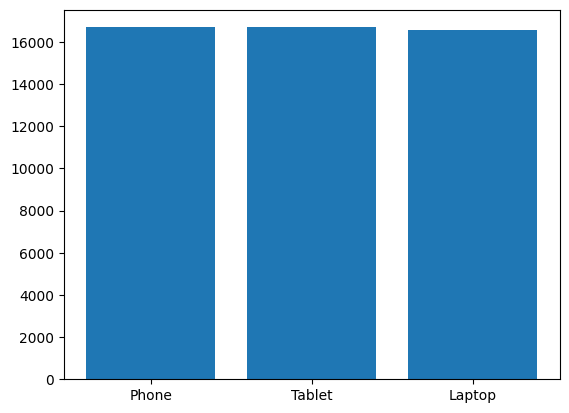

In [ ]:
value_counts = data['device'].value_counts()
plt.bar(value_counts.index, value_counts.values)

<BarContainer object of 1 artists>

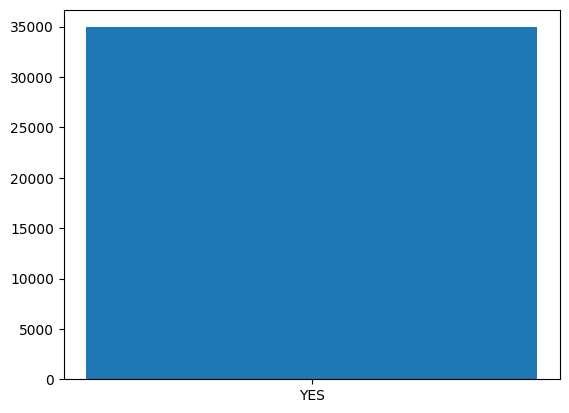

In [ ]:
value_counts = data['on_course'].value_counts()
plt.bar(value_counts.index, value_counts.values)

In [ ]:
X.drop('device', axis=1, inplace=True)

In [ ]:
X

,coach,hs_marks,12_app,inter_marks,income,dummy,board,on_course,cat,pwd,age,sex
0,NO,80.5,NO,92.200000,59000,NO,Maharashtra Board,YES,General-EWS,NO,20,M
1,NO,83.3,YES,87.419339,390000,NO,BSEB,YES,ST,NO,18,F
2,NO,76.4,YES,87.419339,3140000,NO,CBSE,NaN,OBC-NCL,NO,18,M
3,YES,89.7,NO,79.400000,345000,YES,HP Board,NaN,SC,NO,21,M
4,YES,98.9,NO,95.300000,29000,NO,CBSE,NaN,SC,YES,17,M
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,YES,78.3,NO,94.200000,147000,NO,GSEB,YES,ST,NO,18,M
99996,NO,93.7,YES,87.419339,442000,NO,CBSE,YES,Minority,NO,20,F
99997,YES,76.8,YES,87.419339,43000,NO,CBSE,NaN,General,NO,19,M
99998,YES,87.0,NO,96.800000,85000,YES,UP Board,NaN,General-EWS,NO,18,F


In [ ]:
X['on_course'] = X['on_course'].fillna('NO')

In [ ]:
X

,coach,hs_marks,12_app,inter_marks,income,dummy,board,on_course,cat,pwd,age,sex
0,NO,80.5,NO,92.200000,59000,NO,Maharashtra Board,YES,General-EWS,NO,20,M
1,NO,83.3,YES,87.419339,390000,NO,BSEB,YES,ST,NO,18,F
2,NO,76.4,YES,87.419339,3140000,NO,CBSE,NO,OBC-NCL,NO,18,M
3,YES,89.7,NO,79.400000,345000,YES,HP Board,NO,SC,NO,21,M
4,YES,98.9,NO,95.300000,29000,NO,CBSE,NO,SC,YES,17,M
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,YES,78.3,NO,94.200000,147000,NO,GSEB,YES,ST,NO,18,M
99996,NO,93.7,YES,87.419339,442000,NO,CBSE,YES,Minority,NO,20,F
99997,YES,76.8,YES,87.419339,43000,NO,CBSE,NO,General,NO,19,M
99998,YES,87.0,NO,96.800000,85000,YES,UP Board,NO,General-EWS,NO,18,F


In [ ]:
print(X.isna().sum())

coach          0
hs_marks       0
12_app         0
inter_marks    0
income         0
dummy          0
board          0
on_course      0
cat            0
pwd            0
age            0
sex            0
dtype: int64


In [ ]:
scaler = StandardScaler()

numerical_columns = ['hs_marks', 'inter_marks','income','age']
scaler.fit(X[numerical_columns])
scaled_data = scaler.transform(X[numerical_columns])
for i, col in enumerate(numerical_columns):
    X['scaled_' + col] = scaled_data[:, i]

In [ ]:
X.drop(numerical_columns, axis=1, inplace=True)

In [ ]:
X

,coach,12_app,dummy,board,on_course,cat,pwd,sex,scaled_hs_marks,scaled_inter_marks,scaled_income,scaled_age
0,NO,NO,NO,Maharashtra Board,YES,General-EWS,NO,M,-0.960002,0.849966,-0.438280,0.876842
1,NO,YES,NO,BSEB,YES,ST,NO,F,-0.574427,0.000000,-0.063489,-0.292577
2,NO,YES,NO,CBSE,NO,OBC-NCL,NO,M,-1.524593,0.000000,3.050335,-0.292577
3,YES,NO,YES,HP Board,NO,SC,NO,M,0.306886,-1.425780,-0.114443,1.461551
4,YES,NO,NO,CBSE,NO,SC,YES,M,1.573774,1.401124,-0.472249,-0.877286
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,YES,NO,NO,GSEB,YES,ST,NO,M,-1.262953,1.205552,-0.338638,-0.292577
99996,NO,YES,NO,CBSE,YES,Minority,NO,F,0.857707,0.000000,-0.004610,0.876842
99997,YES,YES,NO,CBSE,NO,General,NO,M,-1.469511,0.000000,-0.456397,0.292132
99998,YES,NO,YES,UP Board,NO,General-EWS,NO,F,-0.064918,1.667813,-0.408841,-0.292577


In [ ]:
#one-hot-encoding
categorical_columns = ['coach', '12_app', 'dummy', 'board', 'on_course', 'cat', 'pwd', 'sex']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X[['coach', '12_app', 'dummy', 'board', 'on_course', 'cat', 'pwd', 'sex']])
encoded_data = encoder.transform(X[['coach', '12_app', 'dummy', 'board', 'on_course', 'cat', 'pwd', 'sex']])
new_columns = encoder.get_feature_names_out(categorical_columns)
X[new_columns] = encoded_data



In [ ]:
X.drop(categorical_columns, axis=1, inplace=True)

In [ ]:
X

,scaled_hs_marks,scaled_inter_marks,scaled_income,scaled_age,coach_NO,coach_YES,12_app_NO,12_app_YES,dummy_NO,dummy_YES,...,cat_General,cat_General-EWS,cat_Minority,cat_OBC-NCL,cat_SC,cat_ST,pwd_NO,pwd_YES,sex_F,sex_M
0,-0.960002,0.849966,-0.438280,0.876842,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.574427,0.000000,-0.063489,-0.292577,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,-1.524593,0.000000,3.050335,-0.292577,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.306886,-1.425780,-0.114443,1.461551,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.573774,1.401124,-0.472249,-0.877286,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.262953,1.205552,-0.338638,-0.292577,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
99996,0.857707,0.000000,-0.004610,0.876842,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
99997,-1.469511,0.000000,-0.456397,0.292132,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
99998,-0.064918,1.667813,-0.408841,-0.292577,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(95000, 42)
(95000,)


In [ ]:
len(X_train.keys())

42

In [ ]:
def build_model(alpha):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation='relu',
                              input_shape=[len(X_train.keys())]),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model with specified optimizer and loss function for binary classification
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model



In [ ]:
model1 = build_model(0.00001)
model2 = build_model(0.01)
model3 = build_model(0.001)

In [ ]:
model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 1024)              44032     
                                                                 
 dense_73 (Dense)            (None, 512)               524800    
                                                                 
 dense_74 (Dense)            (None, 256)               131328    
                                                                 
 dense_75 (Dense)            (None, 128)               32896     
                                                                 
 dense_76 (Dense)            (None, 64)                8256      
                                                                 
 dense_77 (Dense)            (None, 1)                 65        
                                                                 
Total params: 741377 (2.83 MB)
Trainable params: 7413

In [ ]:
# #mini-batch implementation
X_train_tensor = tf.convert_to_tensor(X_train)
Y_train_tensor = tf.convert_to_tensor(y_train)


In [ ]:
mini_batch_size=512
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, Y_train_tensor))
train_dataset = train_dataset.repeat().shuffle(buffer_size=1000).batch(mini_batch_size)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95000 entries, 62989 to 15795
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   scaled_hs_marks          95000 non-null  float64
 1   scaled_inter_marks       95000 non-null  float64
 2   scaled_income            95000 non-null  float64
 3   scaled_age               95000 non-null  float64
 4   coach_NO                 95000 non-null  float64
 5   coach_YES                95000 non-null  float64
 6   12_app_NO                95000 non-null  float64
 7   12_app_YES               95000 non-null  float64
 8   dummy_NO                 95000 non-null  float64
 9   dummy_YES                95000 non-null  float64
 10  board_AP Board           95000 non-null  float64
 11  board_BSEB               95000 non-null  float64
 12  board_CBSE               95000 non-null  float64
 13  board_CGBSE              95000 non-null  float64
 14  board_GSEB             

In [ ]:
Y_train_tensor

<tf.Tensor: shape=(95000,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 1])>

In [ ]:
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',  # Monitor validation accuracy (adjust if needed)
#     min_delta=0.001,  # Minimum change in accuracy to consider improvement
#     patience=5,  # Number of epochs to wait without improvement before stopping
#     restore_best_weights=True  # Restore the weights with the best validation accuracy
# )

In [ ]:
model1.fit(X_train_tensor, Y_train_tensor,
          epochs=100,  # Adjust the number of epochs based on your data
          validation_data=(X_test, y_test),  # Include validation data
)

Epoch 1/100
2969/2969 [==============================] - 13s 4ms/step - loss: 0.2096 - accuracy: 0.9164 - val_loss: 0.1353 - val_accuracy: 0.9294
Epoch 2/100
2969/2969 [==============================] - 11s 4ms/step - loss: 0.1299 - accuracy: 0.9305 - val_loss: 0.1245 - val_accuracy: 0.9300
Epoch 3/100
2969/2969 [==============================] - 11s 4ms/step - loss: 0.1244 - accuracy: 0.9309 - val_loss: 0.1215 - val_accuracy: 0.9312
Epoch 4/100
2969/2969 [==============================] - 11s 4ms/step - loss: 0.1218 - accuracy: 0.9309 - val_loss: 0.1205 - val_accuracy: 0.9300
Epoch 5/100
2969/2969 [==============================] - 11s 4ms/step - loss: 0.1196 - accuracy: 0.9325 - val_loss: 0.1180 - val_accuracy: 0.9328
Epoch 6/100
2969/2969 [==============================] - 11s 4ms/step - loss: 0.1180 - accuracy: 0.9331 - val_loss: 0.1184 - val_accuracy: 0.9336
Epoch 7/100
2969/2969 [==============================] - 11s 4ms/step - loss: 0.1165 - accuracy: 0.9336 - val_loss: 0.1170 -

KeyboardInterrupt: 

In [ ]:
X_dev,y_dev = X_test, y_test

In [ ]:
model1.evaluate(X_dev, y_dev)

157/157 [==============================] - 0s 2ms/step - loss: 0.1127 - accuracy: 0.9334


[0.11269688606262207, 0.9333999752998352]

In [ ]:
test_dat = pd.read_csv('/kaggle/input/yamunas-odyssey-a-dream-to-conquer-iit-jammu/test.csv')
test_dat.head()

,Roll No,Name,Caoching,High School Marks,12th Appearing,Intermediate Marks,Income,Dummy,School Board,Device to Study,Online Course,Category,PwD,Age,Sex
0,546722345,GIJPQ ZYZPW,YES,87.3,NO,83.5,393000,NO,AP Board,NaN,NaN,General-EWS,NO,16,M
1,546722346,YJMBL EIQFA,YES,81.9,YES,NaN,174000,NO,Maharashtra Board,Tablet,YES,OBC-NCL,NO,21,F
2,546722347,POTQM FVTEG,YES,75.8,YES,NaN,13000,YES,Goa Board,NaN,NaN,General-EWS,NO,21,F
3,546722348,VNPZP BMQTZ,NO,97.8,NO,98.7,122000,NO,CBSE,Laptop,YES,ST,NO,19,M
4,546722349,CDAAU LMXVV,YES,90.0,NO,93.6,124000,NO,MP Board,Phone,NaN,SC,NO,16,F


In [ ]:
ids = test_dat['Roll No']
test_dat.drop(['Roll No', 'Name'], axis=1, inplace=True)

In [ ]:
test_dat.rename(columns={'Caoching':'coach', 'High School Marks':'hs_marks', '12th Appearing':'12_app', 'Intermediate Marks':'inter_marks', 'Income':'income', 'Dummy':'dummy', 'School Board':'board', 'Device to Study':'device', 'Online Course':'on_course', 'Category':'cat', 'PwD':'pwd', 'Age':'age', 'Sex':'sex','Passed':'pass'}, inplace=True)

In [ ]:
print(test_dat.isna().sum())

coach             0
hs_marks          0
12_app            0
inter_marks    1926
income            0
dummy             0
board             0
device         2466
on_course      3231
cat               0
pwd               0
age               0
sex               0
dtype: int64


In [ ]:
inter_mean

87.41933942632637

In [ ]:
test_dat['inter_marks'] = test_dat['inter_marks'].fillna(inter_mean)

In [ ]:
test_dat.head()

,coach,hs_marks,12_app,inter_marks,income,dummy,board,device,on_course,cat,pwd,age,sex
0,YES,87.3,NO,83.500000,393000,NO,AP Board,NaN,NaN,General-EWS,NO,16,M
1,YES,81.9,YES,87.419339,174000,NO,Maharashtra Board,Tablet,YES,OBC-NCL,NO,21,F
2,YES,75.8,YES,87.419339,13000,YES,Goa Board,NaN,NaN,General-EWS,NO,21,F
3,NO,97.8,NO,98.700000,122000,NO,CBSE,Laptop,YES,ST,NO,19,M
4,YES,90.0,NO,93.600000,124000,NO,MP Board,Phone,NaN,SC,NO,16,F


In [ ]:
test_dat['on_course'] = test_dat['on_course'].fillna('NO')
test_dat.head()

,coach,hs_marks,12_app,inter_marks,income,dummy,board,device,on_course,cat,pwd,age,sex
0,YES,87.3,NO,83.500000,393000,NO,AP Board,NaN,NO,General-EWS,NO,16,M
1,YES,81.9,YES,87.419339,174000,NO,Maharashtra Board,Tablet,YES,OBC-NCL,NO,21,F
2,YES,75.8,YES,87.419339,13000,YES,Goa Board,NaN,NO,General-EWS,NO,21,F
3,NO,97.8,NO,98.700000,122000,NO,CBSE,Laptop,YES,ST,NO,19,M
4,YES,90.0,NO,93.600000,124000,NO,MP Board,Phone,NO,SC,NO,16,F


In [ ]:
test_dat.isna().sum()

coach             0
hs_marks          0
12_app            0
inter_marks       0
income            0
dummy             0
board             0
device         2466
on_course         0
cat               0
pwd               0
age               0
sex               0
dtype: int64

In [ ]:
scaled_data = scaler.transform(test_dat[numerical_columns])
for i, col in enumerate(numerical_columns):
    test_dat['scaled_' + col] = scaled_data[:, i]

In [ ]:
test_dat.drop(numerical_columns, axis=1, inplace=True)
test_dat.head()

,coach,12_app,dummy,board,device,on_course,cat,pwd,sex,scaled_hs_marks,scaled_inter_marks,scaled_income,scaled_age
0,YES,NO,NO,AP Board,NaN,NO,General-EWS,NO,M,-0.023606,-0.696830,-0.060092,-1.461996
1,YES,YES,NO,Maharashtra Board,Tablet,YES,OBC-NCL,NO,F,-0.767214,0.000000,-0.308066,1.461551
2,YES,YES,YES,Goa Board,NaN,NO,General-EWS,NO,F,-1.607216,0.000000,-0.490366,1.461551
3,NO,NO,NO,CBSE,Laptop,YES,ST,NO,M,1.422298,2.005619,-0.366945,0.292132
4,YES,NO,NO,MP Board,Phone,NO,SC,NO,F,0.348198,1.098876,-0.364681,-1.461996


In [ ]:
encoded_data = encoder.transform(test_dat[['coach', '12_app', 'dummy', 'board', 'on_course', 'cat', 'pwd', 'sex']])
new_columns = encoder.get_feature_names_out(categorical_columns)
test_dat[new_columns] = encoded_data

In [ ]:
test_dat.drop(categorical_columns, axis=1, inplace=True)

In [ ]:
test_dat.head()

,device,scaled_hs_marks,scaled_inter_marks,scaled_income,scaled_age,coach_NO,coach_YES,12_app_NO,12_app_YES,dummy_NO,...,cat_General,cat_General-EWS,cat_Minority,cat_OBC-NCL,cat_SC,cat_ST,pwd_NO,pwd_YES,sex_F,sex_M
0,NaN,-0.023606,-0.696830,-0.060092,-1.461996,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,Tablet,-0.767214,0.000000,-0.308066,1.461551,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,NaN,-1.607216,0.000000,-0.490366,1.461551,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Laptop,1.422298,2.005619,-0.366945,0.292132,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,Phone,0.348198,1.098876,-0.364681,-1.461996,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
test_dat.drop('device', axis=1, inplace=True)

In [ ]:
test_dat.head()

,scaled_hs_marks,scaled_inter_marks,scaled_income,scaled_age,coach_NO,coach_YES,12_app_NO,12_app_YES,dummy_NO,dummy_YES,...,cat_General,cat_General-EWS,cat_Minority,cat_OBC-NCL,cat_SC,cat_ST,pwd_NO,pwd_YES,sex_F,sex_M
0,-0.023606,-0.696830,-0.060092,-1.461996,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.767214,0.000000,-0.308066,1.461551,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-1.607216,0.000000,-0.490366,1.461551,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.422298,2.005619,-0.366945,0.292132,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.348198,1.098876,-0.364681,-1.461996,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
test_pred = model1.predict(test_dat)

157/157 [==============================] - 0s 2ms/step


In [ ]:
test_pred

array([[0.9999254 ],
       [0.98998344],
       [0.99999905],
       ...,
       [0.00427288],
       [0.0062625 ],
       [0.9998971 ]], dtype=float32)

In [ ]:
prob = pd.DataFrame(test_pred, columns=['Pass'])
df_final = pd.concat([ids, prob], axis=1)
def pass_fail_converter(value):
    return "PASS" if value >= 0.80 else "FAIL"
df_final["Passed"] = df_final["Pass"].apply(pass_fail_converter)
df_final.drop("Pass", axis=1, inplace=True)
df_final.head()


,Roll No,Passed
0,546722345,PASS
1,546722346,PASS
2,546722347,PASS
3,546722348,FAIL
4,546722349,PASS


In [ ]:
print(df_final)

        Roll No Passed
0     546722345   PASS
1     546722346   PASS
2     546722347   PASS
3     546722348   FAIL
4     546722349   PASS
...         ...    ...
4995  546727340   PASS
4996  546727341   PASS
4997  546727342   FAIL
4998  546727343   FAIL
4999  546727344   PASS

[5000 rows x 2 columns]


In [ ]:
df_final.to_csv('submission.csv', index=False)